In [3]:
import pandas as pd
import numpy as np
import gensim

In [17]:
import gensim.models.word2vec as w2v

In [67]:
import nltk
import glob
import codecs
import re
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
!pip install seaborn

    100% |████████████████████████████████| 184kB 3.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for seaborn ... done
  Stored in directory: /root/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from nltk.tokenize import PunktSentenceTokenizer

In [7]:
!ls /data

sherlock1.txt  sherlock2.txt  sherlock3.txt


In [8]:
def clean_sentences(sentence):
    cleaned_sentence = re.sub("[^a-zA-Z]", " ", sentence)
    words = cleaned_sentence.split()
    return words

In [9]:
book_names = glob.glob("/data/*.txt")

In [10]:
book_names

['/data/sherlock1.txt', '/data/sherlock2.txt', '/data/sherlock3.txt']

In [11]:
corpus = ""
for book_filename in book_names:
    print("{0}".format(book_filename))
    with codecs.open(book_filename,"r","utf-8") as book:
        corpus += book.read()
    print("corpus is now {0} charcters".format(len(corpus)))

/data/sherlock1.txt
corpus is now 604896 charcters
/data/sherlock2.txt
corpus is now 1245204 charcters
/data/sherlock3.txt
corpus is now 1510753 charcters


In [6]:
corpus

'\ufeff\r\nA SCANDAL IN BOHEMIA\r\nI\r\nTo Sherlock Holmes she is always _the_ woman. I have seldom heard\r\nhim mention her under any other name. In his eyes she eclipses and\r\npredominates the whole of her sex. It was not that he felt any emotion\r\nakin to love for Irene Adler. All emotions, and that one particularly,\r\nwere abhorrent to his cold, precise, but admirably balanced mind. He\r\nwas, I take it, the most perfect reasoning and observing machine that\r\nthe world has seen; but, as a lover, he would have placed himself in a\r\nfalse position. He never spoke of the softer passions, save with a gibe\r\nand a sneer. They were admirable things for the observer—excellent\r\nfor drawing the veil from men’s motives and actions. But for the\r\ntrained reasoner to admit such intrusions into his own delicate and\r\nfinely adjusted temperament was to introduce a distracting factor which\r\nmight throw a doubt upon all his mental results. Grit in a sensitive\r\ninstrument, or a crack 

In [12]:
tokenizer = PunktSentenceTokenizer("english")

In [13]:
raw_sentences = tokenizer.tokenize(corpus)

In [14]:
len(raw_sentences)

14175

In [15]:
sentences = []
for sentence in raw_sentences:
#     print(sentence)
#     print("*"*10)
    if len(sentence) > 0:
        sentences.append(clean_sentences(sentence))

In [33]:
len(sentences)

14175

In [16]:
print(raw_sentences[89])
sentences[89]

There’s money in this case, Watson, if there
is nothing else.”

“I think that I had better go, Holmes.”

“Not a bit, doctor.


['There',
 's',
 'money',
 'in',
 'this',
 'case',
 'Watson',
 'if',
 'there',
 'is',
 'nothing',
 'else',
 'I',
 'think',
 'that',
 'I',
 'had',
 'better',
 'go',
 'Holmes',
 'Not',
 'a',
 'bit',
 'doctor']

In [20]:
num_features = 500
min_word_count = 5
#get window size
context_size = 7
downsampling = 1e-3
seed = 1


In [30]:
sherlock2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)

In [31]:
sherlock2vec.build_vocab(sentences)

In [32]:
print("Word2Vec Vocabulary length = {0}".format(len(sherlock2vec.wv.vocab)))

Word2Vec Vocabulary length = 4339


In [41]:
print(sherlock2vec.epochs)

None


In [42]:
sherlock2vec.train(sentences,total_examples=sherlock2vec.corpus_count, epochs=10)

(1852182, 2749320)

In [43]:
sherlock2vec.save("sherlock2vec.w2v")

In [50]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
vector_matrix = sherlock2vec.wv.syn0

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [51]:
vector_matrix.shape

(4339, 500)

In [52]:
word_vectors_2d_matrix = tsne.fit_transform(vector_matrix)

In [54]:
word_vectors_2d_matrix.shape

(4339, 2)

In [56]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_vectors_2d_matrix[sherlock2vec.wv.vocab[word].index])
            for word in sherlock2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [57]:
points.head(10)

,word,x,y
0,inquiring,0.264760,-4.236930
1,grace,0.453626,-1.989963
2,penetrating,-4.003317,2.822891
3,reach,-3.279943,-5.163152
4,accompanied,-1.659641,-4.833973
5,low,-6.571366,-4.268158
6,etc,0.710443,-6.058322
7,Most,0.782099,-0.112298
8,pills,2.751648,-4.669249
9,pursuers,-1.254414,-5.176568


In [62]:
sns.set_context("poster")

In [110]:
?points.plot.scatter

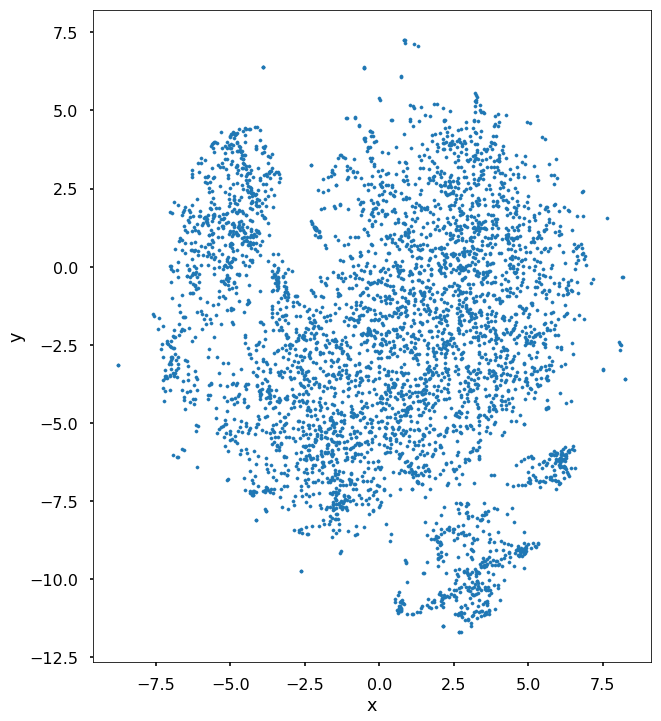

In [109]:
points.plot.scatter("x","y", s=10, figsize=(10,12))

In [128]:
def plot_region(xbounds,ybounds):
    slice = points[
        (xbounds[0] <= points.x) &
        (points.x <= xbounds[1]) &
        (ybounds[0] <= points.y) &
        (points.y <= ybounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(12,10), c="red")
    ax.set_facecolor((0, 0.6,0.8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=10)

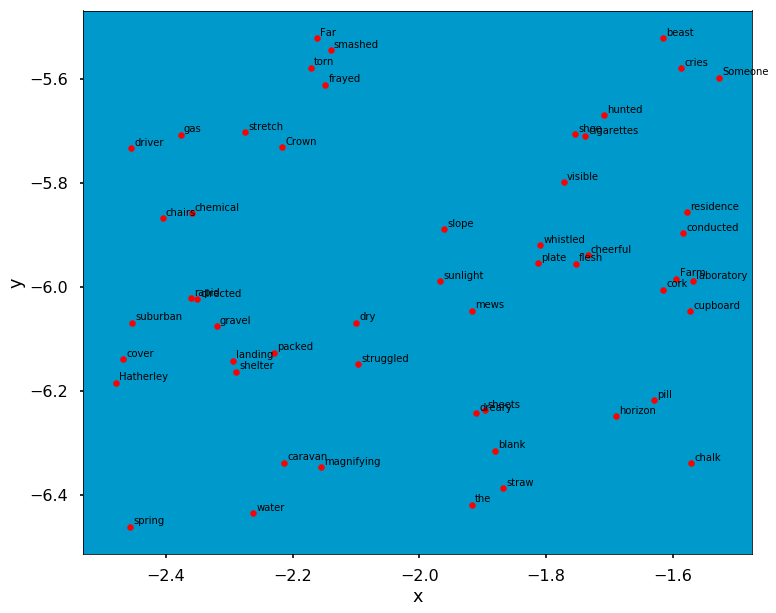

In [129]:
plot_region(xbounds=(-2.5,-1.5),ybounds=(-6.5,-5.5))

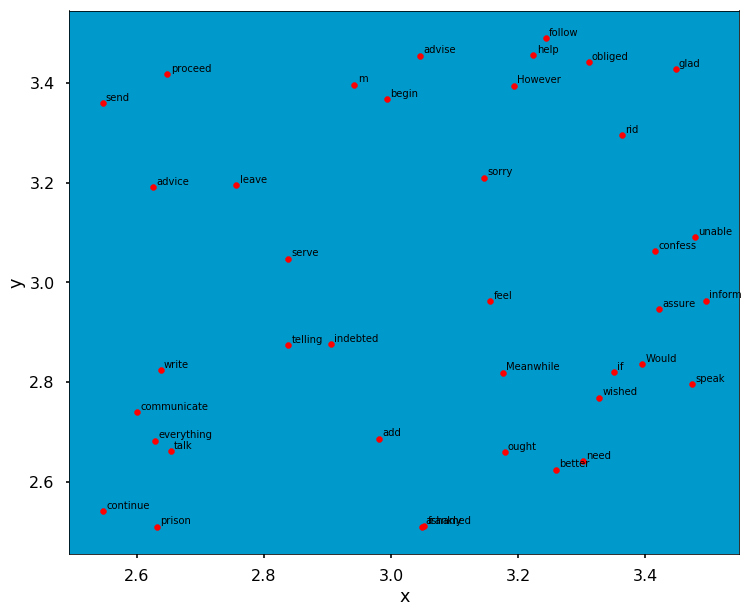

In [130]:
plot_region(xbounds=(2.5,3.5),ybounds=(2.5,3.5))

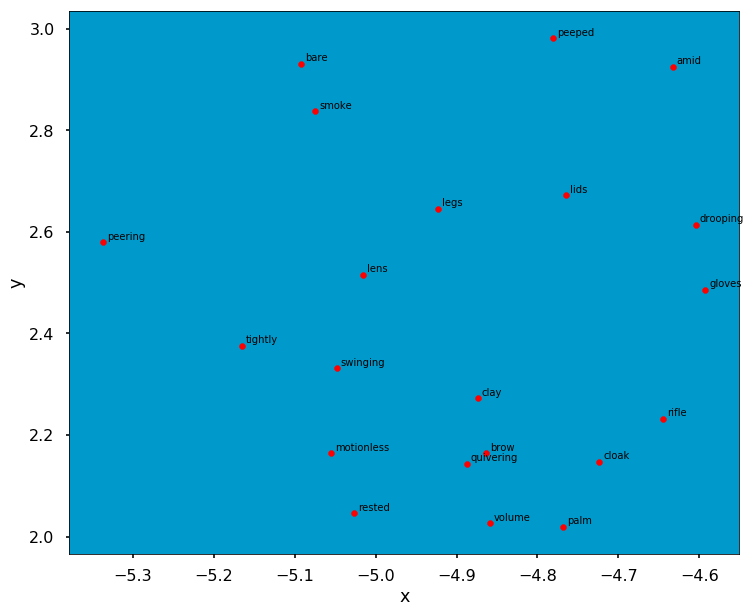

In [131]:
plot_region(xbounds=(-5.5,-4.5),ybounds=(2,3))

In [88]:
sherlock2vec.most_similar("Moriarty")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pursued', 0.8744404315948486),
 ('club', 0.8736170530319214),
 ('rifled', 0.8632193803787231),
 ('attacked', 0.8622997999191284),
 ('Ralph', 0.855709969997406),
 ('disaster', 0.8556134700775146),
 ('declared', 0.8515156507492065),
 ('Major', 0.8509087562561035),
 ('Horner', 0.8507382869720459),
 ('distinguished', 0.8495466113090515)]

In [136]:
sherlock2vec.most_similar("Sherlock")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('rising', 0.7558963894844055),
 ('sharply', 0.7279722690582275),
 ('heartily', 0.7096605896949768),
 ('thoughtfully', 0.6992692947387695),
 ('laughing', 0.6978948712348938),
 ('Gregson', 0.69370436668396),
 ('gravely', 0.6899236440658569),
 ('injustice', 0.68767249584198),
 ('sternly', 0.6841943264007568),
 ('gracious', 0.6757276058197021)]

In [100]:
sherlock2vec.most_similar("McCarthy")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Heidegger', 0.8597038984298706),
 ('Stangerson', 0.8510388731956482),
 ('Black', 0.8489305973052979),
 ('murdered', 0.8448321223258972),
 ('William', 0.8403312563896179),
 ('devil', 0.8386131525039673),
 ('Openshaw', 0.8383774757385254),
 ('master', 0.838219404220581),
 ('Wilder', 0.8367891907691956),
 ('firm', 0.8278963565826416)]

In [104]:
sherlock2vec.most_similar("murdered")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('William', 0.8549082279205322),
 ('Wilder', 0.8540186882019043),
 ('Cooee', 0.8511686325073242),
 ('McCarthy', 0.8448320627212524),
 ('Heidegger', 0.8330777883529663),
 ('student', 0.8282724618911743),
 ('favor', 0.8247765898704529),
 ('Patrick', 0.8235840797424316),
 ('firm', 0.8207359313964844),
 ('richest', 0.8207238912582397)]

In [105]:
sherlock2vec.most_similar("Watson")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Doctor', 0.7936356067657471),
 ('congratulate', 0.778719425201416),
 ('solved', 0.7671012878417969),
 ('tut', 0.745442807674408),
 ('Jove', 0.7348896265029907),
 ('progress', 0.7342016696929932),
 ('madam', 0.7222010493278503),
 ('thank', 0.7212780117988586),
 ('bye', 0.7211863398551941),
 ('joking', 0.7202016711235046)]

In [107]:
sherlock2vec.most_similar("Lestrade")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Gregson', 0.7954769730567932),
 ('laughing', 0.7845392823219299),
 ('Inspector', 0.7681878805160522),
 ('detective', 0.7514921426773071),
 ('rising', 0.7388495206832886),
 ('Yard', 0.7324785590171814),
 ('Stamford', 0.7319767475128174),
 ('inspector', 0.7309200763702393),
 ('Scotland', 0.7241195440292358),
 ('pointing', 0.7230656147003174)]

In [113]:
sherlock2vec.most_similar("murderer")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('deed', 0.8162039518356323),
 ('confederate', 0.805957555770874),
 ('Wilder', 0.7974935173988342),
 ('Willoughby', 0.7757222056388855),
 ('robbery', 0.7745275497436523),
 ('motive', 0.7724540829658508),
 ('abroad', 0.7713098526000977),
 ('Boone', 0.7710646390914917),
 ('notorious', 0.764551043510437),
 ('Openshaw', 0.7625547647476196)]

Get linear relationship between words

In [134]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = sherlock2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [135]:
nearest_similarity_cosmul("Moriarty","Watson", "Sherlock")
# nearest_similarity_cosmul("Jaime", "sword", "wine")
# nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Doctor is related to Watson, as thoughtfully is related to Sherlock


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'thoughtfully'